# ANALISIS IRRADIANCIA OBTENIDA EN 1 DIA: SOLSTICIO DE VERANO

In [37]:
import module_Cell as cell
import module_AoiGrids as gr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pvlib import location
from pvlib import irradiance

Definimos como diccionarios los valores útiles del modulo y de las caracteristicas del lugar a estudiar. Tomamos un radio algo mayor que el spot, que en AOI=0 el spot es de radio aproximado 1mm

In [38]:
caracteristics_module={    
    'tilt':0, #Techo plano
    'surface_azimuth':180,
    'radius':1.2 #Radio inventado, se ha considerado que el spote en aoi=0 es sobre 1, entonces se ha puesto algo mayor
    }

caracteristics={
    'lat':40.405655,
    'lon':-3.647649,
    'tz':'Etc/GMT-2',
    'date':'21-06-2020',
    }

Trabajando con la librería pvlib obtenemos los datos para esta localización de la posición solar

In [39]:
site = location.Location(caracteristics['lat'], 
                         caracteristics['lon'],
                        caracteristics['tz'])
                                                      
times = pd.date_range(caracteristics['date'], freq='10min', periods=6*24,
                      tz=site.tz)
clearsky = site.get_clearsky(times)
solar_position = site.get_solarposition(times)

A partir de estos datos podemos obtener la distribución de irradiancias y el aoi a lo largo del día. 

In [40]:
total_irrad=irradiance.get_total_irradiance( 
    surface_tilt=caracteristics_module['tilt'],
    surface_azimuth=caracteristics_module['surface_azimuth'],
    dni=clearsky['dni'],
    ghi=clearsky['ghi'],
    dhi=clearsky['dhi'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])

In [41]:
AOI_=irradiance.aoi( caracteristics_module['tilt'],
                   caracteristics_module['surface_azimuth'],
                   solar_position['apparent_zenith'], 
                   solar_position['azimuth'])

Para seguir los convenios elegidos, el AOI se decide pasar a negativo los valores mayores a 90º y se relaciona con el indice de tiempos. 

In [42]:
AOI=gr.transform_aoi(AOI_)
AOI.index = AOI.index.strftime("%H:%M")

## OBTENCIÓN ILUMINACIÓN 1 DÍA CON LA CÉLULA SIN MOVER

Definimos la célula en un punto fijo durante todo el día. Por comodidad tomamos el 0,0. Se opta por una celula circular, podría usarse también una celula rectangular: rectangular_cell(l1,l2,desx,desy,precision=0.04)

In [43]:
cell_grid=cell.circular_cell(caracteristics_module['radius'], 0, 0)


Calculamos el valor de la irradiancia total que atraviesa la célula. Primero la definimos copiando el AOI para que sea una matriz serie de iguales dimensiones y también indice de tiempos.

Para cada indice de tiempo: 
1. Guardamos en spot la matriz de distirbución de irradiación que tenemos como datos (csv)
2. Aplicamos intersección entre esta matriz y anterior y la matriz conformada por la celula.
    2.1 Los tramos de intersección, será irradiancia utilizada para electricidad
    2.2 Los tramos de no intersección, será irradiancia utilizada para iluminación <- LA QUE ESTAMOS ESTUDIANDO
3. Sumando la matriz obtenida de los tramos de no intersección  ????????
4. Multiplicamos esta matriz por la irradiación directa total que obtenemos para ese tiempo y además sumamos toda la irradiación difusa. 
- Se ha hecho una función para esto, pero lo dejo ya desarrollado

In [44]:
irradiance = np.empty_like (AOI)
for i in range(len(times)):    
    spot=gr.spot_grid(AOI[i])
    area_illum,area_elect=cell.areas_intersection(spot,cell_grid)
    irradiance[i]=area_illum.sum()*total_irrad['poa_direct'][i]+total_irrad['poa_diffuse'][i]  

Dibujamos la distribución obtenida. 
En verde: irradiancia directa total
En naranja: irradiancia difusa
En azul: irradiancia obtenida para la iluminación que pasa a través de la célula

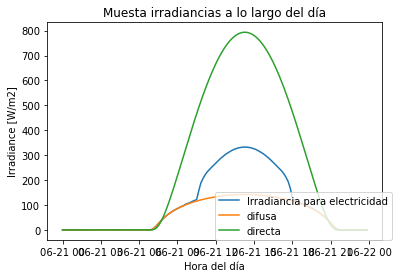

In [45]:
plt.plot(times,irradiance,label='Irradiancia para electricidad')
plt.plot(times,total_irrad['poa_diffuse'],label='difusa')
plt.plot(times,total_irrad['poa_direct'],label='directa')


plt.legend(loc=(0.5, 0))
plt.xlabel('Hora del día')
plt.ylabel('Irradiance [W/m2]')
plt.title("Muesta irradiancias a lo largo del día")

plt.show()

## OBTENCIÓN ILUMINACIÓN 1 DÍA CON LA CÉLULA MOVIENDOSE. OBJETIVO IRRADIANCIA PARA ILUMINACIÓN CONSTANTE


Definimos la célula pero no en un punto fijo durante todo el día. El objetivo va a ser dejar a 250W/m2 la irradiancia 

Se opta por una celula circular, podría usarse también una celula rectangular. Copiamos el valor de AOI para que sea una serie de igual dimensiones y con el indice de tiempos. Lo mismo con irradiance


 ## PROGRAMACIÓN DEL AJUSTE

Definimos el valor de irradiancia que queremos constante:

In [49]:
val_irradiance=250

Buscamos los limites en los que se consigue este valor, considerando que no hay celula y se consigue toda la irradiación. Concluimos que antes de la primera vez que se alcanza el valor deseado y después de la última vez, se va a buscar captar toda la irradiancia posible. (es decir la celula no tendrá interseccion con el spot)

In [50]:
a=0
for i in range(len(times)):    
    spot=gr.spot_grid(AOI[i])
    irradiance[i]=spot.sum()*total_irrad['poa_direct'][i]+total_irrad['poa_diffuse'][i]  
    if irradiance[i]>val_irradiance and a==0:
        a=1
        MIN_=i
    if irradiance[i]<val_irradiance and a==1:
        a=0
        MAX_=i

Sabemos que del estudio del spot obtenido para distintos aoi, el desplazamiento es:
1. 60º->40º desplazamiento positivo en x
2. 40º->0º desplazamiento negativo en x
3. 0º>AOI>-40º desplzamiento negativo en x
4. -40º>AOI>-60º desplazameinto positivo en x


Creamos un vector para guardar los valores dx,dy que se obtienen:

In [70]:
desp=np.empty(len(times),float)
for i in range(len(times)): 
    if i<=MIN_ or i>=MAX_:
        dx=0
        dy=3
        irradiance[i]=cell.irradiance_cell(caracteristics_module['radius'], dx, dy,AOI[i],total_irrad['poa_direct'][i],
                        total_irrad['poa_diffuse'][i]) 
       
    else:
        if AOI[i]>0:
            dx=1.5
            dy=0
        else:
            dx=-1.5
            dy=0
        irradiance[i]=cell.irradiance_cell(caracteristics_module['radius'], dx, dy,AOI[i],total_irrad['poa_direct'][i],
                      total_irrad['poa_diffuse'][i])       
        while irradiance[i]>1.05*val_irradiance or irradiance[i]<0.95*val_irradiance:
            if  AOI[i]>0:
                dx=dx-0.02
            elif AOI[i]<0:
                dx=dx+0.02
            else:
                dx=dx-0.02
            irradiance[i]=cell.irradiance_cell(caracteristics_module['radius'], dx, dy,AOI[i],total_irrad['poa_direct'][i],
                           total_irrad['poa_diffuse'][i])    
            print(irradiance[i],i,dx,dy,AOI[i])
    desp[i]=dx        
    print(irradiance[i],i,dx,dy,AOI[i])

0.0 0 0 3 90.0
0.0 1 0 3 90.0
0.0 2 0 3 90.0
0.0 3 0 3 90.0
0.0 4 0 3 90.0
0.0 5 0 3 90.0
0.0 6 0 3 90.0
0.0 7 0 3 90.0
0.0 8 0 3 90.0
0.0 9 0 3 90.0
0.0 10 0 3 90.0
0.0 11 0 3 90.0
0.0 12 0 3 90.0
0.0 13 0 3 90.0
0.0 14 0 3 90.0
0.0 15 0 3 90.0
0.0 16 0 3 90.0
0.0 17 0 3 90.0
0.0 18 0 3 90.0
0.0 19 0 3 90.0
0.0 20 0 3 90.0
0.0 21 0 3 90.0
0.0 22 0 3 90.0
0.0 23 0 3 90.0
0.0 24 0 3 90.0
0.0 25 0 3 90.0
0.0 26 0 3 90.0
0.0 27 0 3 90.0
0.0 28 0 3 90.0
0.0 29 0 3 90.0
0.0 30 0 3 90.0
0.0 31 0 3 90.0
0.0 32 0 3 90.0
0.0 33 0 3 90.0
0.0 34 0 3 90.0
0.0 35 0 3 90.0
0.0 36 0 3 90.0
0.0 37 0 3 90.0
0.0 38 0 3 90.0
0.0 39 0 3 90.0
0.0 40 0 3 90.0
0.08397899750889566 41 0 3 89.49546121443825
1.785790667063297 42 0 3 88.03100764838663
7.192503781155362 43 0 3 86.45876234269375
15.534449471251824 44 0 3 84.82299900789837
24.984606484546315 45 0 3 83.1447778631045
34.35841673481174 46 0 3 81.43435866505827
43.13516027714697 47 0 3 79.69749150838406
51.15694778697444 48 0 3 77.93787898026386
58.4272

143.9810023741491 74 1.48 0 29.748008605292593
143.9810023741491 74 1.46 0 29.748008605292593
144.6276309667585 74 1.44 0 29.748008605292593
144.6276309667585 74 1.42 0 29.748008605292593
145.3752588440718 74 1.4 0 29.748008605292593
145.3752588440718 74 1.38 0 29.748008605292593
146.22751889340884 74 1.3599999999999999 0 29.748008605292593
146.22751889340884 74 1.3399999999999999 0 29.748008605292593
147.26232220383437 74 1.3199999999999998 0 29.748008605292593
147.26232220383437 74 1.2999999999999998 0 29.748008605292593
148.99920590131674 74 1.2799999999999998 0 29.748008605292593
148.99920590131674 74 1.2599999999999998 0 29.748008605292593
152.53344404829167 74 1.2399999999999998 0 29.748008605292593
152.53344404829167 74 1.2199999999999998 0 29.748008605292593
158.84475390457413 74 1.1999999999999997 0 29.748008605292593
158.84475390457413 74 1.1799999999999997 0 29.748008605292593
167.97209832494428 74 1.1599999999999997 0 29.748008605292593
167.97209832494428 74 1.1399999999999

152.17567497439603 81 1.2599999999999998 0 19.582666855672308
153.05332367964797 81 1.2399999999999998 0 19.582666855672308
153.05332367964797 81 1.2199999999999998 0 19.582666855672308
154.02460193847236 81 1.1999999999999997 0 19.582666855672308
154.02460193847236 81 1.1799999999999997 0 19.582666855672308
155.3183456975083 81 1.1599999999999997 0 19.582666855672308
155.3183456975083 81 1.1399999999999997 0 19.582666855672308
157.76398426774784 81 1.1199999999999997 0 19.582666855672308
157.76398426774784 81 1.0999999999999996 0 19.582666855672308
162.68777143230162 81 1.0799999999999996 0 19.582666855672308
162.68777143230162 81 1.0599999999999996 0 19.582666855672308
170.82564421556359 81 1.0399999999999996 0 19.582666855672308
170.82564421556359 81 1.0199999999999996 0 19.582666855672308
181.58681942856347 81 0.9999999999999996 0 19.582666855672308
181.58681942856347 81 0.9799999999999995 0 19.582666855672308
193.8341904660549 81 0.9599999999999995 0 19.582666855672308
193.8341904

153.36622588753696 85 1.2199999999999998 0 17.020991077909905
154.45202719095082 85 1.1999999999999997 0 17.020991077909905
154.45202719095082 85 1.1799999999999997 0 17.020991077909905
156.43844507946727 85 1.1599999999999997 0 17.020991077909905
156.43844507946727 85 1.1399999999999997 0 17.020991077909905
160.39891474387224 85 1.1199999999999997 0 17.020991077909905
160.39891474387224 85 1.0999999999999996 0 17.020991077909905
167.16602470557058 85 1.0799999999999996 0 17.020991077909905
167.16602470557058 85 1.0599999999999996 0 17.020991077909905
176.64692132014932 85 1.0399999999999996 0 17.020991077909905
176.64692132014932 85 1.0199999999999996 0 17.020991077909905
187.94123760864733 85 0.9999999999999996 0 17.020991077909905
187.94123760864733 85 0.9799999999999995 0 17.020991077909905
200.11213754014983 85 0.9599999999999995 0 17.020991077909905
200.11213754014983 85 0.9399999999999995 0 17.020991077909905
212.81034994971048 85 0.9199999999999995 0 17.020991077909905
212.8103

155.872511007109 89 -1.1599999999999997 0 -18.371260099670728
159.02865694304217 89 -1.1399999999999997 0 -18.371260099670728
159.02865694304217 89 -1.1199999999999997 0 -18.371260099670728
164.81781464359165 89 -1.0999999999999996 0 -18.371260099670728
164.81781464359165 89 -1.0799999999999996 0 -18.371260099670728
173.58803059891912 89 -1.0599999999999996 0 -18.371260099670728
173.58803059891912 89 -1.0399999999999996 0 -18.371260099670728
184.60327941324888 89 -1.0199999999999996 0 -18.371260099670728
184.60327941324888 89 -0.9999999999999996 0 -18.371260099670728
196.8197963394054 89 -0.9799999999999995 0 -18.371260099670728
196.8197963394054 89 -0.9599999999999995 0 -18.371260099670728
209.77440550524503 89 -0.9399999999999995 0 -18.371260099670728
209.77440550524503 89 -0.9199999999999995 0 -18.371260099670728
223.6430310852785 89 -0.8999999999999995 0 -18.371260099670728
223.6430310852785 89 -0.8799999999999994 0 -18.371260099670728
238.333107189711 89 -0.8599999999999994 0 -18.

160.9951447360992 96 -1.46 0 -27.563694725424874
160.9951447360992 96 -1.44 0 -27.563694725424874
170.48205902654198 96 -1.42 0 -27.563694725424874
170.48205902654198 96 -1.4 0 -27.563694725424874
181.99038872684025 96 -1.38 0 -27.563694725424874
181.99038872684025 96 -1.3599999999999999 0 -27.563694725424874
194.74545928230344 96 -1.3399999999999999 0 -27.563694725424874
194.74545928230344 96 -1.3199999999999998 0 -27.563694725424874
208.03409223998375 96 -1.2999999999999998 0 -27.563694725424874
208.03409223998375 96 -1.2799999999999998 0 -27.563694725424874
220.90438812638178 96 -1.2599999999999998 0 -27.563694725424874
220.90438812638178 96 -1.2399999999999998 0 -27.563694725424874
232.43344773098767 96 -1.2199999999999998 0 -27.563694725424874
232.43344773098767 96 -1.1999999999999997 0 -27.563694725424874
242.23179832969427 96 -1.1799999999999997 0 -27.563694725424874
242.23179832969427 96 -1.1799999999999997 0 -27.563694725424874
145.00679137780708 97 -1.48 0 -29.23646828971578


218.9532610780766 100 -0.9199999999999995 0 -34.50690448951552
225.37250039412098 100 -0.8999999999999995 0 -34.50690448951552
225.37250039412098 100 -0.8799999999999994 0 -34.50690448951552
231.1178593381013 100 -0.8599999999999994 0 -34.50690448951552
231.1178593381013 100 -0.8399999999999994 0 -34.50690448951552
236.35707009155482 100 -0.8199999999999994 0 -34.50690448951552
236.35707009155482 100 -0.7999999999999994 0 -34.50690448951552
241.14166615475725 100 -0.7799999999999994 0 -34.50690448951552
241.14166615475725 100 -0.7799999999999994 0 -34.50690448951552
141.06675490192768 101 -1.48 0 -36.324269568031646
142.01283146213913 101 -1.46 0 -36.324269568031646
142.01283146213913 101 -1.44 0 -36.324269568031646
143.32618409015973 101 -1.42 0 -36.324269568031646
143.32618409015973 101 -1.4 0 -36.324269568031646
145.36810758578267 101 -1.38 0 -36.324269568031646
145.36810758578267 101 -1.3599999999999999 0 -36.324269568031646
148.69632472967234 101 -1.3399999999999999 0 -36.32426956

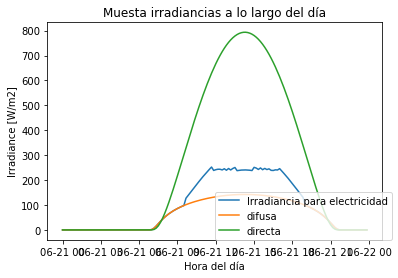

In [71]:
plt.plot(times,irradiance,label='Irradiancia para electricidad')
plt.plot(times,total_irrad['poa_diffuse'],label='difusa')
plt.plot(times,total_irrad['poa_direct'],label='directa')


plt.legend(loc=(0.5, 0))
plt.xlabel('Hora del día')
plt.ylabel('Irradiance [W/m2]')
plt.title("Muesta irradiancias a lo largo del día")

plt.show()

Comentario: El programa está simplificado puesto que solo hay aoi entre 40 a -40. Si se pide una irradiancai constante mas baja habría que revisar el programa. Además es muy poco eficiente a nivel del rendimiento(proceso muy lento)

Valor de dx obtenido:

In [78]:
print(desp)

[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.8
  0.8   0.84  0.88  1.12  1.28  1.44  1.24  1.08  0.92  0.8   0.84  0.84
  0.84  0.84 -0.86 -0.86 -0.86 -0.86 -0.82 -0.9  -1.06 -1.22 -1.38 -1.34
 -1.18 -0.94 -0.9  -0.86 -0.78 -0.78  0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]


### PROBLEMAS DE INCOHERENCIA

#### 1. PASO DEL AOI NEGATIVO A POSITIVO

Al tener un tilt=0, no se consigue que el módulo tenga un aoi=0 en ningun momento. Para ello en Madrid se necesita en verano un tilt=17. Entonces, se obtiene una pequeña incoherencia a nivel del dibujo, cuando consideramos que se pasa a valores negativos:

1. Spot a las 14:10 AOI=17
2. Spot a a las 14.20 AOI=-17

In [ ]:
spot=gr.spot_grid(AOI[85])
gr.plot_grid('14:10',spot)
spot_2=gr.spot_grid(AOI[86])
gr.plot_grid('14:20',spot_2)

Por lo tanto también es incoherente el desplazamiento de la celula que se busca. Puesto que se pasa de un desplazamiento en x positivo a uno negativo. 

 ### COMPROBACIÓN FUNCIONAMIENTO PRINCIPAL PROGRAMA

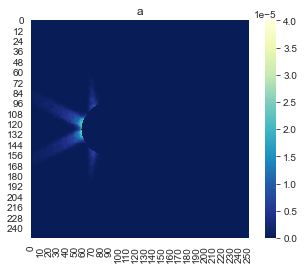

149.41021702585576


In [67]:
i=87
cell_grid_2=cell.circular_cell(caracteristics_module['radius'], -1.5 ,0)
spot_2=gr.spot_grid(AOI[i])
area_illum_2,area_elect_2=cell.areas_intersection(spot_2,cell_grid_2)
gr.plot_grid('a',area_illum_2) 
irradiance_2[i]=area_illum_2.sum()*total_irrad['poa_direct'][i]+total_irrad['poa_diffuse'][i] 
print(irradiance_2[i])